In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

try:
    from scapy.all import rdpcap, IP, TCP, UDP
    SCAPY_AVAILABLE = True
except ModuleNotFoundError:
    SCAPY_AVAILABLE = False
    print(
        " Scapy is not installed.\n"
        "Run the following command to enable packet analysis:\n"
        "!pip install scapy"
    )

import subprocess

print("Libraries loaded successfully.")
print(f"Scapy available: {SCAPY_AVAILABLE}")


 Scapy is not installed.
Run the following command to enable packet analysis:
!pip install scapy
Libraries loaded successfully.
Scapy available: False


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install scapy if not installed
!pip install scapy

# Import scapy
from scapy.all import rdpcap

# Correct file path
file_path = "/content/drive/My Drive/Captured Dataset Wireshark.pcapng"

# Read packets
packets = rdpcap(file_path)

print(f"Loaded {len(packets)} packets")


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.5 MB/s eta 0:00:00
Loaded 603 packets


In [3]:
import pandas as pd
import seaborn as sns
from scapy.all import IP, TCP, UDP

# Set visualization style
sns.set(style="whitegrid")

records = []

for pkt in packets:
    # Ensure packet has IP layer
    if pkt.haslayer(IP):

        # Determine protocol
        if pkt.haslayer(TCP):
            proto = "TCP"
        elif pkt.haslayer(UDP):
            proto = "UDP"
        else:
            proto = "OTHER"

        records.append({
            "src_ip": pkt[IP].src,
            "dst_ip": pkt[IP].dst,
            "length": pkt[IP].len if pkt[IP].len else len(pkt),
            "protocol": proto,
            "ttl": pkt[IP].ttl
        })

# Create DataFrame
df = pd.DataFrame(records)

# Preview
df.head()


,src_ip,dst_ip,length,protocol,ttl
0,10.196.83.13,98.91.98.198,77,TCP,128
1,10.196.83.13,34.237.151.200,52,TCP,128
2,10.196.83.13,10.196.83.198,74,UDP,128
3,10.196.83.13,10.196.83.198,74,UDP,128
4,10.196.83.13,10.196.83.198,74,UDP,128


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   src_ip    594 non-null    object
 1   dst_ip    594 non-null    object
 2   length    594 non-null    int64 
 3   protocol  594 non-null    object
 4   ttl       594 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 23.3+ KB


In [5]:
df.describe()

,length,ttl
count,594.000000,594.000000
mean,394.835017,126.526936
std,554.170425,54.177587
min,40.000000,45.000000
25%,40.000000,99.000000
50%,65.000000,128.000000
75%,480.500000,128.000000
max,1420.000000,251.000000


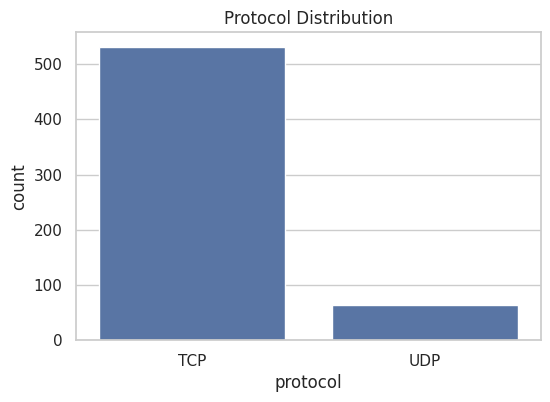

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='protocol')
plt.title("Protocol Distribution")
plt.show()

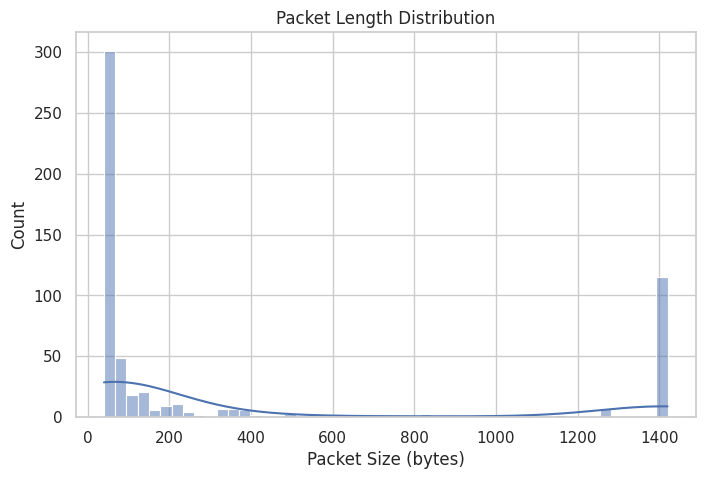

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df['length'], bins=50, kde=True)
plt.title("Packet Length Distribution")
plt.xlabel("Packet Size (bytes)")
plt.show()

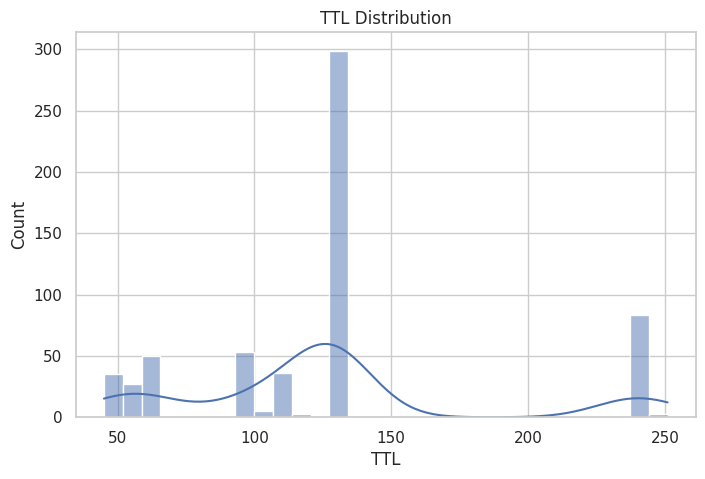

In [10]:
plt.figure(figsize=(8,5))
sns.histplot(df['ttl'], bins=30, kde=True)
plt.title("TTL Distribution")
plt.xlabel("TTL")
plt.show()

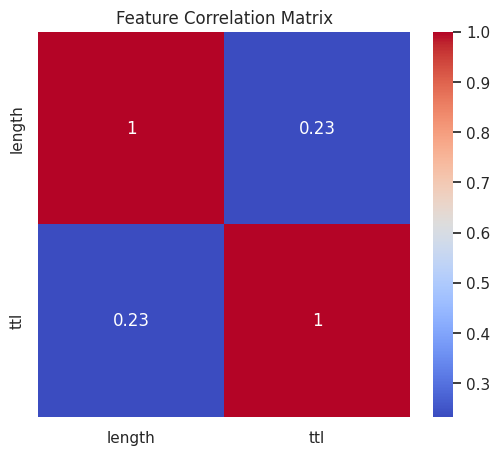

In [12]:
plt.figure(figsize=(6,5))
sns.heatmap(df[['length','ttl']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [14]:
import pandas as pd

# Convert timestamp if not present
df["timestamp"] = pd.to_datetime(df.index, unit="s", errors="ignore")

# Group packets into flows
flow_df = df.groupby(["src_ip", "dst_ip", "protocol"]).agg(
    packet_count=("length", "count"),
    byte_count=("length", "sum"),
    ttl_mean=("ttl", "mean")
).reset_index()

flow_df.head()
from sklearn.preprocessing import StandardScaler

features = flow_df[["packet_count", "byte_count", "ttl_mean"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

iso_forest.fit(X_scaled)

# Predict anomalies
flow_df["anomaly"] = iso_forest.predict(X_scaled)

# -1 = anomaly, 1 = normal
flow_df["anomaly"] = flow_df["anomaly"].map({1: 0, -1: 1})

flow_df.head()


/tmp/ipython-input-860395364.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df["timestamp"] = pd.to_datetime(df.index, unit="s", errors="ignore")


,src_ip,dst_ip,protocol,packet_count,byte_count,ttl_mean,anomaly
0,10.196.83.13,10.196.83.198,UDP,19,1272,128.0,0
1,10.196.83.13,10.196.83.255,UDP,1,229,128.0,0
2,10.196.83.13,104.19.168.59,TCP,11,674,128.0,0
3,10.196.83.13,108.156.2.25,TCP,2,82,128.0,0
4,10.196.83.13,13.107.246.63,TCP,14,3259,128.0,0


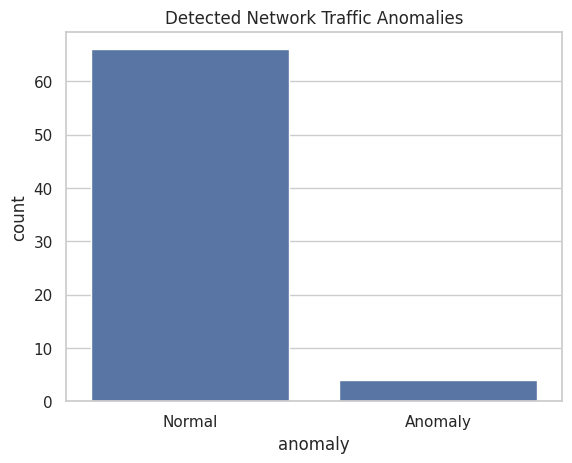

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="anomaly", data=flow_df)
plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.title("Detected Network Traffic Anomalies")
plt.show()


In [16]:
malicious_ips = flow_df[flow_df["anomaly"] == 1]["src_ip"].unique()

print(" Detected Malicious IPs:")
for ip in malicious_ips:
    print(ip)


 Detected Malicious IPs:
10.196.83.13
20.190.177.21
52.1.211.13
54.243.191.95
